In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from load_data import LoadDataset

In [2]:
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, LSTM, Bidirectional, Reshape, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# tf.compat.v1.keras.backend.set_session(InteractiveSession(config=config))

In [3]:
selected_features = ['destination_port',
            'init_win_bytes_backward',
            'init_win_bytes_forward',
            'bwd_packets_s',
            'fwd_iat_min',
            'min_seg_size_forward',
            'flow_iat_min',
            'flow_duration',
            'total_length_of_fwd_packets',
            'total_backward_packets',
            'bwd_iat_min',
            'bwd_packet_length_std',
            'fwd_iat_total',
            'fwd_packet_length_mean',
            'fwd_packet_length_max',
            'flow_iat_std',
            'fwd_packets_s',
            'down_up_ratio',
            'total_fwd_packets',
            'bwd_packet_length_min',
            'flow_bytes_s',
            'bwd_header_length',
            'packet_length_mean',
            'total_length_of_bwd_packets',
            "label"]

In [4]:
df_test = LoadDataset("./raw/raw_testset.csv", columns = selected_features)

In [5]:
df_train = LoadDataset("./oversampling/NRAS_trainset.csv", columns = selected_features)

In [6]:
X_train = df_train.drop('label', axis = 1)
y_train = df_train['label']

X_test = df_test.drop('label', axis = 1)
y_test = df_test['label']

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
y_train_categorical = to_categorical(y_train, num_classes = 10)
y_test_categorical = to_categorical(y_test, num_classes = 10)

In [9]:
print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("Y_test Shape: ", y_test.shape)

X_train Shape:  (9539966, 24)
Y_train Shape:  (9539966,)
X_test Shape:  (756690, 24)
Y_test Shape:  (756690,)


In [10]:
model = Sequential([
    Conv1D(64, kernel_size=24, padding="same", activation="relu", input_shape=(24, 1)),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=False)),
    Reshape((128, 1), input_shape=(128,)),
    BatchNormalization(),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

In [11]:
model = tf.keras.models.load_model("./checkpoint/bisltm_weights.h5")

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            1600      
                                                                 
 batch_normalization (BatchN  (None, 24, 64)           256       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 1)           4         
 hNormalization)                                                 
                                                        

In [13]:
opt = Adam(learning_rate = 1.2500e-04)
model.compile(loss='categorical_crossentropy',
              optimizer = opt, 
              metrics = ['accuracy'])

In [14]:
checkpoint = ModelCheckpoint("./checkpoint/bisltm_weights_1.h5", 
                             monitor = 'val_loss', verbose = 1, 
                             save_best_only = True, mode = 'min')

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 2, min_lr = 0.00001, verbose = 1)

In [16]:
hist = model.fit(X_train, y_train_categorical,
                 validation_data = (X_test, y_test_categorical),
                 epochs = 10, batch_size = 64,
                 callbacks = [checkpoint, reduce_lr])

Epoch 1/10
149062/149062 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9584
Epoch 1: val_loss improved from inf to 0.10893, saving model to ./checkpoint\bisltm_weights_1.h5
149062/149062 [==============================] - 6570s 44ms/step - loss: 0.0960 - accuracy: 0.9584 - val_loss: 0.1089 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 2/10
149061/149062 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9598
Epoch 2: val_loss improved from 0.10893 to 0.08272, saving model to ./checkpoint\bisltm_weights_1.h5
149062/149062 [==============================] - 6488s 44ms/step - loss: 0.0910 - accuracy: 0.9598 - val_loss: 0.0827 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 3/10
149062/149062 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9583
Epoch 3: val_loss did not improve from 0.08272
149062/149062 [==============================] - 7115s 48ms/step - loss: 0.0995 - accuracy: 0.9583 - val_loss: 0.1455 - val_accuracy: 0.9543 

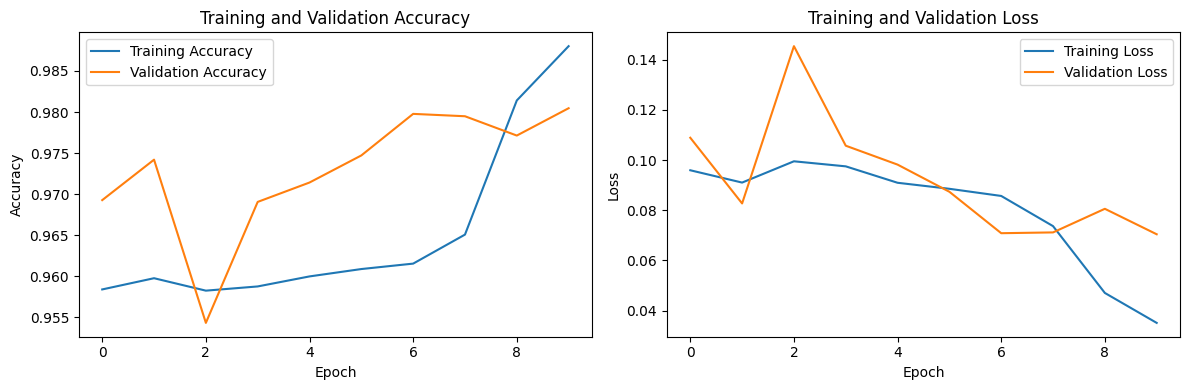

In [22]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [19]:
predictions = model.predict(X_test)

predicted_labels = tf.argmax(predictions, axis=1)
true_labels = tf.argmax(y_test_categorical, axis=1)

precision_per_class = precision_score(true_labels, predicted_labels, average=None)

23647/23647 [==============================] - 423s 18ms/step


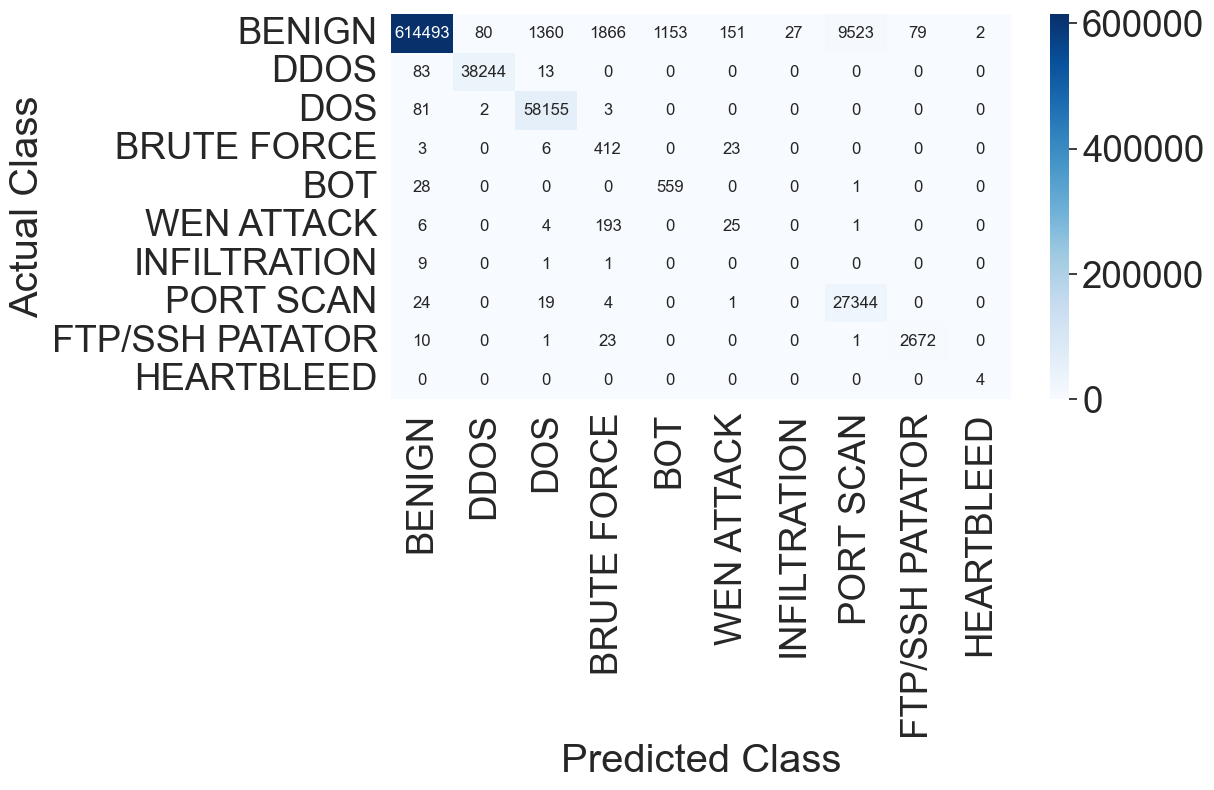

In [32]:
labels = ['BENIGN','DDOS','DOS', 'BRUTE FORCE', 'BOT', 'WEN ATTACK', "INFILTRATION", "PORT SCAN", "FTP/SSH PATATOR", "HEARTBLEED"]

confMat = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(confMat)

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2.4)
sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels = labels, yticklabels = labels, cmap='Blues')

plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 